In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/D325_FinalPro/ieee-fraud-detection/

/content/drive/.shortcut-targets-by-id/1DjRvvcy3LDabuYpOjI8Z2WCk5FiSW3ZX/D325_FinalPro/ieee-fraud-detection


In [ ]:
ls

sample_submission.csv  test_transaction.csv  train_transaction.csv
test_identity.csv      train_identity.csv


In [4]:
data = "./"
train_iden = data + "train_identity.csv"
test_iden = data + "test_identity.csv"
train_trans = data + "train_transaction.csv"
test_trans = data + "test_transaction.csv"
sample_sub = data + "sample_submission.csv"

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

import os
import tempfile

import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_classification
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn import svm

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
#from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

## Neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
from sklearn.inspection import permutation_importance

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [6]:
train_identity = pd.read_csv(train_iden)
test_identity = pd.read_csv(test_iden)
train_transaction = pd.read_csv(train_trans)
test_transaction = pd.read_csv(test_trans)

In [ ]:
print(train_identity.shape[1])
print(train_transaction.shape)

41
(590540, 394)


In [ ]:
train_transaction.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
V335              float64
V336              float64
V337              float64
V338              float64
V339              float64
Length: 394, dtype: object

In [ ]:
train_transaction.head(n = 1)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:

chosen_factor = ['isFraud', 'TransactionAmt', 'ProductCD', 'card1', 'card2','card3','card4','card5','card6','dist1','P_emaildomain']
neural_factor = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
train_new = train_transaction[chosen_factor+neural_factor]
train_new.head(n= 5)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,NaN,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


Text(0.5, 1.0, 'Correlation between variables')

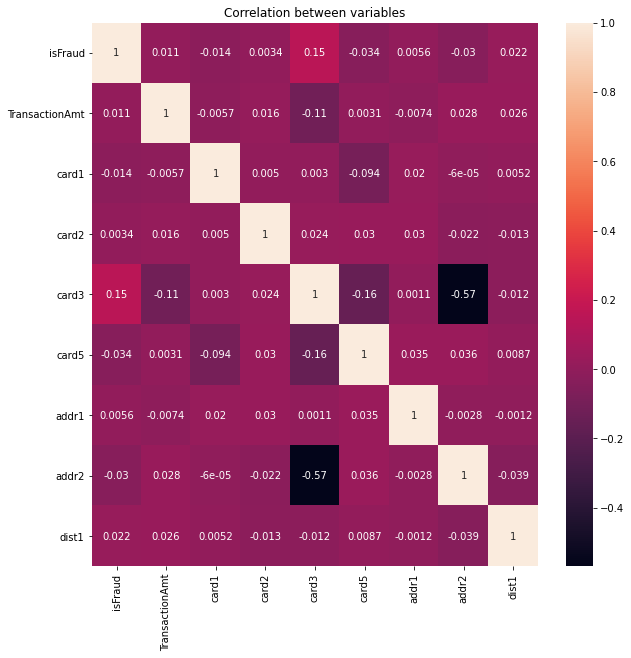

In [ ]:
train_corr_var = train_new.drop(columns=['ProductCD','card4','card6','P_emaildomain','R_emaildomain'])
train_corr_var.head(n= 5)

train_corr = train_corr_var.corr()
fig, ax = plt.subplots(figsize = (10,10))
g= sns.heatmap(train_corr,ax=ax, annot= True)
ax.set_title('Correlation between variables')

In [ ]:
response_corr = train_corr_var.corr()['isFraud']
print(response_corr)

isFraud           1.000000
TransactionAmt    0.011320
card1            -0.013640
card2             0.003388
card3             0.154151
card5            -0.033580
addr1             0.005596
addr2            -0.030387
dist1             0.021522
Name: isFraud, dtype: float64


In [ ]:
np.sum(
        train_transaction["TransactionID"].isin(
            train_identity["TransactionID"].unique()
        )
    )/train_transaction.shape[0]

0.2442391709283029

In [45]:
def change(amt):
    num = 0
    while((int(amt)*10 != int(amt*10)) and (num < 3)):
        num = num + 1
        amt = amt * 10
    return num

train_new["TransactionAmt_decimal"] = train_new["TransactionAmt"].map(change)
print(train_new.head(n=20))

    isFraud  TransactionAmt ProductCD  ...   C13  C14  TransactionAmt_decimal
0         0          68.500         W  ...   1.0  1.0                       1
1         0          29.000         W  ...   1.0  1.0                       0
2         0          59.000         W  ...   1.0  1.0                       0
3         0          50.000         W  ...  25.0  1.0                       0
4         0          50.000         H  ...   1.0  1.0                       0
5         0          49.000         W  ...   1.0  1.0                       0
6         0         159.000         W  ...   1.0  1.0                       0
7         0         422.500         W  ...   1.0  1.0                       1
8         0          15.000         H  ...   1.0  1.0                       0
9         0         117.000         W  ...  12.0  2.0                       0
10        0          75.887         C  ...   2.0  1.0                       3
11        0          16.495         C  ...   1.0  1.0           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


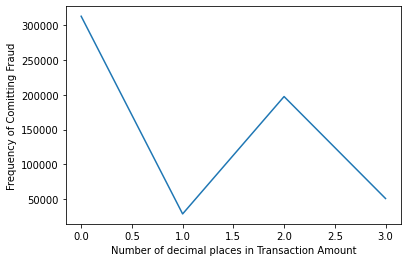

In [8]:
train_new.groupby("TransactionAmt_decimal").count()["isFraud"].plot()
plt.xlabel("Number of decimal places in Transaction Amount")
plt.ylabel("Frequency of Comitting Fraud")
plt.show()

In [15]:
df1 = train_new.groupby("TransactionAmt_decimal").count()["isFraud"]
df1.head()

TransactionAmt_decimal
0    312797
1     29051
2    197525
3     51167
Name: isFraud, dtype: int64

In [17]:
df1 = train_new[train_new['isFraud'] == 1]
df1.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,TransactionAmt_decimal
203,1,445.000,W,18268,583.0,150.0,visa,226.0,credit,NaN,aol.com,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,0
240,1,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,hotmail.com,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
243,1,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
245,1,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,hotmail.com,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
288,1,155.521,C,16578,545.0,185.0,visa,226.0,credit,NaN,outlook.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3


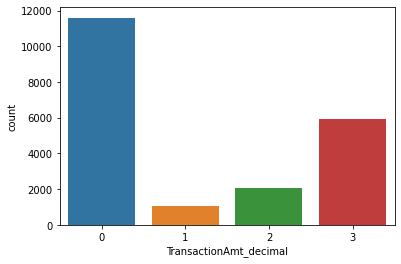

In [18]:
sns.countplot(x ='TransactionAmt_decimal', data = df1)

In [54]:
df1 = train_new[train_new['isFraud'] == 1]
d1 = {'Decimal': ['0','1','2','3+'], 'Count': np.array(df1.groupby("TransactionAmt_decimal").count()["isFraud"])}
df1 = pd.DataFrame(data=d1)
df1

,Decimal,Count
0,0,11591
1,1,1075
2,2,2063
3,3+,5934


In [53]:
df0 = train_new[train_new['isFraud'] == 0]
d0 = {'Decimal': ['0','1','2','3+'], 'Count': np.array(df0.groupby("TransactionAmt_decimal").count()["isFraud"])}
df0 = pd.DataFrame(data=d0)
df0

,Decimal,Count
0,0,301206
1,1,27976
2,2,195462
3,3+,45233


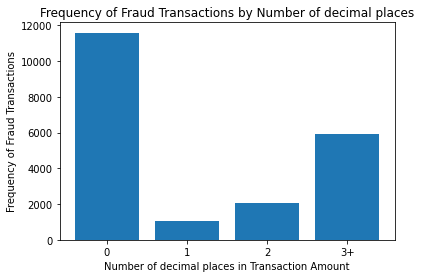

In [66]:
plt.bar(df1['Decimal'], df1['Count'])
plt.xlabel("Number of decimal places in Transaction Amount")
plt.ylabel("Frequency of Fraud Transactions")
plt.title("Frequency of Fraud Transactions by Number of decimal places")
plt.show()

In [57]:
d = {'Decimal': ['0','1','2','3+'], 'Prob': np.array(train_new.groupby("TransactionAmt_decimal").mean()["isFraud"])}
df = pd.DataFrame(data=d)
df

,Decimal,Prob
0,0,0.037056
1,1,0.037004
2,2,0.010444
3,3+,0.115973


In [58]:
dN = {'Decimal': ['0','1','2','3+'], 'Prob': np.array(1-train_new.groupby("TransactionAmt_decimal").mean()["isFraud"])}
dfN = pd.DataFrame(data=dN)
dfN

,Decimal,Prob
0,0,0.962944
1,1,0.962996
2,2,0.989556
3,3+,0.884027


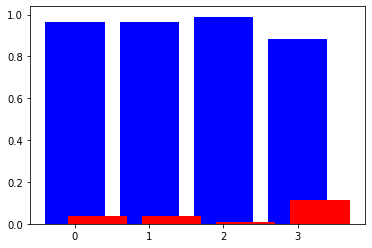

In [62]:
barWidth = 0.3
br1 = np.arange(len(dfN))
br2 = [x + barWidth for x in br1]

plt.bar(br1, np.array(dfN['Prob']), color='blue')
plt.bar(br2, np.array(df['Prob']), color='red')

plt.show()

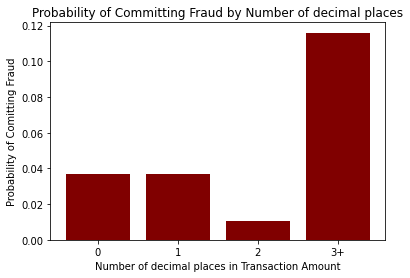

In [65]:
plt.bar(df['Decimal'], df['Prob'], color = 'maroon')
plt.xlabel("Number of decimal places in Transaction Amount")
plt.ylabel("Probability of Comitting Fraud")
plt.title("Probability of Committing Fraud by Number of decimal places")
plt.show()

In [ ]:
train_new.groupby("TransactionAmt_decimal").mean()["isFraud"].plot()
plt.xlabel("Number of decimal places in Transaction Amount")
plt.ylabel("Probability of Committing Fraud")
plt.show()

In [ ]:
train_transaction.iloc[:,30:39].isnull().sum(axis = 0)

In [ ]:
train_transaction.D2.value_counts

<bound method IndexOpsMixin.value_counts of 0           NaN
1           NaN
2           NaN
3         112.0
4           NaN
          ...  
590535     29.0
590536      NaN
590537      NaN
590538     22.0
590539      NaN
Name: D2, Length: 590540, dtype: float64>

In [ ]:
train_transaction.P_emaildomain.value_counts() #Mapping with isFraud

In [ ]:
train_transaction.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [ ]:
20663 / train_transaction.shape[0]

0.03499000914417313

In [ ]:
train_transaction.card4.value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

In [72]:
email_domainFraud = train_transaction["isFraud"].eq(1).groupby(train_transaction["P_emaildomain"]).mean().reset_index()

In [73]:
email_domainFraud.head(n=10)

,P_emaildomain,isFraud
0,aim.com,0.126984
1,anonymous.com,0.023217
2,aol.com,0.021811
3,att.net,0.007439
4,bellsouth.net,0.027763
5,cableone.net,0.018868
6,centurylink.net,0.000000
7,cfl.rr.com,0.000000
8,charter.net,0.030637
9,comcast.net,0.031187


In [83]:
email_domainFraud.sort_values(by="isFraud", ascending=False).head(n=10) #top 5, bar

,P_emaildomain,isFraud
38,protonmail.com,0.407895
29,mail.com,0.189624
36,outlook.es,0.130137
0,aim.com,0.126984
35,outlook.com,0.094584
21,hotmail.es,0.065574
26,live.com.mx,0.054740
19,hotmail.com,0.052950
16,gmail.com,0.043542
57,yahoo.fr,0.034965


In [76]:
df_email = email_domainFraud.sort_values(by="isFraud", ascending=False).head(n=5)
df_email

,P_emaildomain,isFraud
38,protonmail.com,0.407895
29,mail.com,0.189624
36,outlook.es,0.130137
0,aim.com,0.126984
35,outlook.com,0.094584


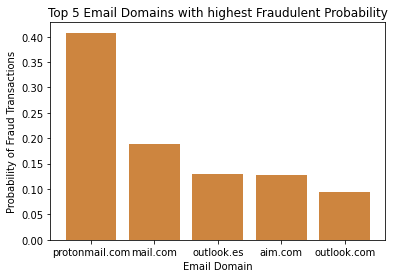

In [81]:
arr_email = np.array(df_email['P_emaildomain'])
arr_fraud = np.array(df_email['isFraud'])

plt.bar(arr_email, arr_fraud, color = 'peru')

plt.xlabel('Email Domain')
plt.ylabel('Probability of Fraud Transactions')
plt.title('Top 5 Email Domains with highest Fraudulent Probability')

plt.show()

In [ ]:
train_transaction.groupby(train_transaction["isFraud"]).dist1.describe() #boxplot

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,233514.0,117.360098,370.641879,0.0,3.0,8.0,24.0,10286.0
1,4755.0,174.588854,424.232313,0.0,3.0,10.0,85.5,4942.0


In [ ]:
233514.0 / (233514.0 + 4755.0)

0.9800435642068418

In [ ]:
fraud1 = train_new[train_new['isFraud'] == 1]
fraud1 = fraud1.dropna()
fraud0 = train_new[train_new['isFraud'] == 0]
fraud0 = fraud0.dropna()
distance = [fraud1['dist1'], fraud0['dist1']]
#print(distance)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


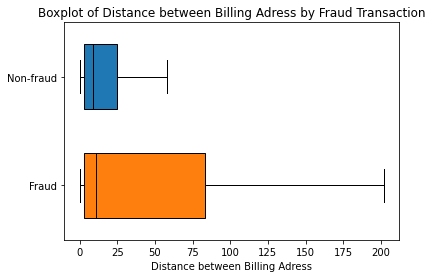

In [69]:
box = plt.boxplot(distance, showfliers=False, vert=False, widths=0.6, labels=['Fraud', 'Non-fraud'], patch_artist=True, medianprops=dict(color='black'))

colors = ['tab:orange', 'tab:blue']
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
  
plt.title('Boxplot of Distance between Billing Adress by Fraud Transaction')
plt.xlabel('Distance between Billing Adress')
# show plot
plt.show()

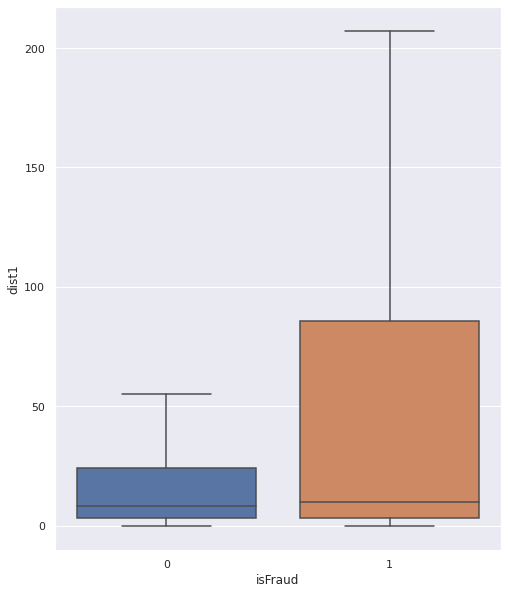

In [ ]:
plt.figure(figsize=(8,10))
sns.boxplot(x = train_new["isFraud"], y = train_new["dist1"], showfliers=False)

In [ ]:
corr_vec = train_transaction.corr()['isFraud']
print(corr_vec)

In [ ]:
neg, pos = np.bincount(train_new['isFraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 590540
    Positive: 20663 (3.50% of total)



In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 14.29


In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-3.31707589])

In [ ]:
train_svm = train_new.copy()
train_svm["P_emaildomain"] = train_svm["P_emaildomain"].astype('category')
train_svm["P_emaildomain"] = train_svm["P_emaildomain"].cat.codes
#train_svm.pop('P_emaildomain')

train_svm["ProductCD"] = train_svm["ProductCD"].astype('category')
train_svm["ProductCD"] = train_svm["ProductCD"].cat.codes
#train_svm.pop('ProductCD')

train_svm["card4"] = train_svm["card4"].astype('category')
train_svm["card4"] = train_svm["card4"].cat.codes
#train_svm.pop('card4')

train_svm["card6"] = train_svm["card6"].astype('category')
train_svm["card6"] = train_svm["card6"].cat.codes
#train_svm.pop('card6')

#train_svm.pop('R_emaildomain')

train_svm = train_svm.fillna(-1)

train_svm.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,0,68.5,4,13926,-1.0,150.0,1,142.0,1,19.0,-1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,0,29.0,4,2755,404.0,150.0,2,102.0,1,-1.0,16,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0,59.0,4,4663,490.0,150.0,3,166.0,2,287.0,35,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0,50.0,4,18132,567.0,150.0,2,117.0,2,-1.0,53,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,0,50.0,1,4497,514.0,150.0,2,102.0,1,-1.0,16,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [ ]:
train_svm.columns.values

array(['isFraud', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5',
       'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'],
      dtype=object)

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(train_svm, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_svm.pop('isFraud'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('isFraud'))
test_labels = np.array(test_df.pop('isFraud'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1406.4117


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
#model.load_weights(initial_bias)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

In [ ]:
svclassifier = svm.SVC(kernel='linear', class_weight = class_weight)
#svclassifier.fit(train_features, train_labels)

In [ ]:
# define model
model = BalancedRandomForestClassifier(n_estimators=10)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
# evaluate model
scores = cross_val_score(model, train_features, train_labels, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: nan


In [ ]:
scale_factor = ['TransactionAmt', 'card1', 'card2','card3','card5', 'dist1', 'C1', 'C2', 'C7', 'C13', 'C14']
train_data = train_new
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data[scale_factor] = scaler.fit_transform(train_data[scale_factor])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [ ]:
train_data.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,0,0.002137,W,0.743044,NaN,0.381679,discover,0.306569,credit,0.001847,NaN,0.000213,0.000176,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.000343,0.0007
1,0,0.000900,W,0.100885,0.608,0.381679,mastercard,0.014599,credit,NaN,gmail.com,0.000213,0.000176,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000343,0.0007
2,0,0.001840,W,0.210566,0.780,0.381679,visa,0.481752,debit,0.027902,outlook.com,0.000213,0.000176,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000343,0.0007
3,0,0.001558,W,0.984824,0.934,0.381679,mastercard,0.124088,debit,NaN,yahoo.com,0.000427,0.000879,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.008568,0.0007
4,0,0.001558,H,0.201023,0.828,0.381679,mastercard,0.014599,credit,NaN,gmail.com,0.000213,0.000176,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000343,0.0007


In [ ]:
target = 'isFraud'
factor = ['TransactionAmt', 'ProductCD', 'card1', 'card2','card3','card4','card5','card6','dist1','P_emaildomain', 'C1', 'C2', 'C7', 'C13', 'C14']
train_data[['ProductCD', 'P_emaildomain', 'card4', 'card6']] = train_data[['ProductCD', 'P_emaildomain', 'card4', 'card6']].astype("category")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
train_data.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,0,0.002137,W,0.743044,NaN,0.381679,discover,0.306569,credit,0.001847,NaN,0.000213,0.000176,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.000343,0.0007
1,0,0.000900,W,0.100885,0.608,0.381679,mastercard,0.014599,credit,NaN,gmail.com,0.000213,0.000176,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000343,0.0007
2,0,0.001840,W,0.210566,0.780,0.381679,visa,0.481752,debit,0.027902,outlook.com,0.000213,0.000176,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000343,0.0007
3,0,0.001558,W,0.984824,0.934,0.381679,mastercard,0.124088,debit,NaN,yahoo.com,0.000427,0.000879,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.008568,0.0007
4,0,0.001558,H,0.201023,0.828,0.381679,mastercard,0.014599,credit,NaN,gmail.com,0.000213,0.000176,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000343,0.0007


In [ ]:
train_df, test_df = train_test_split(train_data, test_size=0.2, random_state = 1)
X_train = train_df[factor]
y_train = train_df[target]
X_test = test_df[factor]
y_test = test_df[target]

In [ ]:
train_data.ProductCD.dtypes

CategoricalDtype(categories=['C', 'H', 'R', 'S', 'W'], ordered=False)

In [ ]:
model = LogisticRegression().fit(X_train, y_train)
threshold = 0.5
model.predict(X_test)

ValueError: ignored

In [ ]:
score = model.score(X_test, y_test)
print(score)

1.0


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=10)
print(scores)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [70]:
final_trans = train_transaction[chosen_factor+neural_factor]
final_trans = train_new.fillna(0)
label = train_new['isFraud']
features = np.array(train_new).astype(np.float32)
label = np.array(label)

ValueError: ignored

In [ ]:
final_trans.columns.values

array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'dist1', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'],
      dtype=object)

In [ ]:
features_train.shape

(472432, 24)

In [ ]:
features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=1)

Feature: 0, Score: 0.13488
Feature: 1, Score: 0.01881
Feature: 2, Score: 0.11510
Feature: 3, Score: 0.08024
Feature: 4, Score: 0.00819
Feature: 5, Score: 0.01114
Feature: 6, Score: 0.02690
Feature: 7, Score: 0.01043
Feature: 8, Score: 0.04445
Feature: 9, Score: 0.05477
Feature: 10, Score: 0.12592
Feature: 11, Score: 0.03987
Feature: 12, Score: 0.00086
Feature: 13, Score: 0.01583
Feature: 14, Score: 0.00671
Feature: 15, Score: 0.02404
Feature: 16, Score: 0.06436
Feature: 17, Score: 0.02051
Feature: 18, Score: 0.02852
Feature: 19, Score: 0.01487
Feature: 20, Score: 0.01687
Feature: 21, Score: 0.01530
Feature: 22, Score: 0.07952
Feature: 23, Score: 0.04192


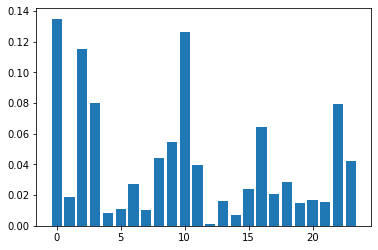

In [ ]:
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(features_train, label_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
most_important = sorted(range(len(importance)), key=lambda i: importance[i])[-10:]
most_important

[11, 23, 8, 9, 16, 22, 3, 2, 10, 0]

In [ ]:
train_svm.columns[most_important]

Index(['C2', 'C14', 'dist1', 'P_emaildomain', 'C7', 'C13', 'card2', 'card1',
       'C1', 'TransactionAmt'],
      dtype='object')